# Interpolation methods

This example compares various interpolation methods available when resizing.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali as dali
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path
import PIL

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

## Downscaling
First, let's define a pipeline that dowscales images aggressively to a fixed size using different interpolation methods:

In [2]:
batch_size = 32

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(path = db_folder, random_shuffle = True, seed = 1234)
    images = dali.fn.decoders.image(files, device = "mixed")
    
    width = 100
    height = 100

    nearest, linear, cubic, triangular, gaussian, lanczos =  (
        dali.fn.resize(images, resize_x=width, resize_y=height, interp_type=interp)
        for interp in [
            dali.types.INTERP_NN,
            dali.types.INTERP_LINEAR,
            dali.types.INTERP_CUBIC,
            dali.types.INTERP_TRIANGULAR,
            dali.types.INTERP_GAUSSIAN,
            dali.types.INTERP_LANCZOS3
        ]
    )
  
    pipe.set_outputs(images, nearest, linear, cubic, triangular, gaussian, lanczos)

pipe.build()
pipe_out = pipe.run()

Let's define a utility for diplaying the output images

In [3]:
def show(pipe_out, idx):
    from synsets import imagenet_synsets
    import matplotlib.gridspec as gridspec
    len_outputs = len(pipe_out)
    methods = ["nearest", "linear", "cubic", "triangular", "Gaussian", "Lanczos"]
    fig = plt.figure(figsize = (16,24))
    plt.suptitle(None)
    columns = 2
    rows = int(math.ceil(len_outputs / columns))
    gs = gridspec.GridSpec(rows, columns)
    for i in range(len_outputs):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(methods[i])
        pipe_out_cpu = pipe_out[i].as_cpu()
        img_chw = pipe_out_cpu.at(idx)
        plt.imshow((img_chw)/255.0)    

Original image


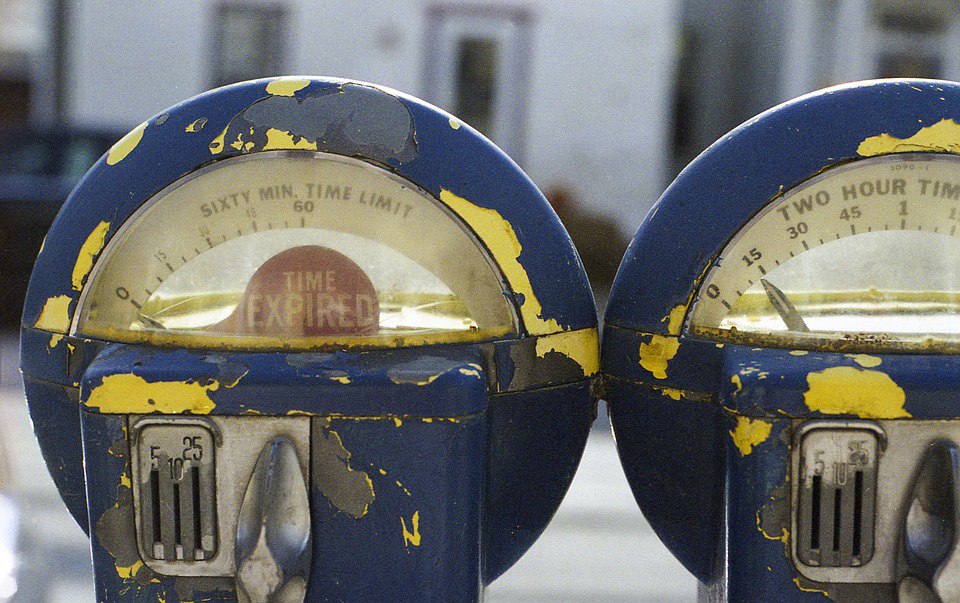

In [4]:
print("Original image")
PIL.Image.fromarray(pipe_out[0].as_cpu().at(5))

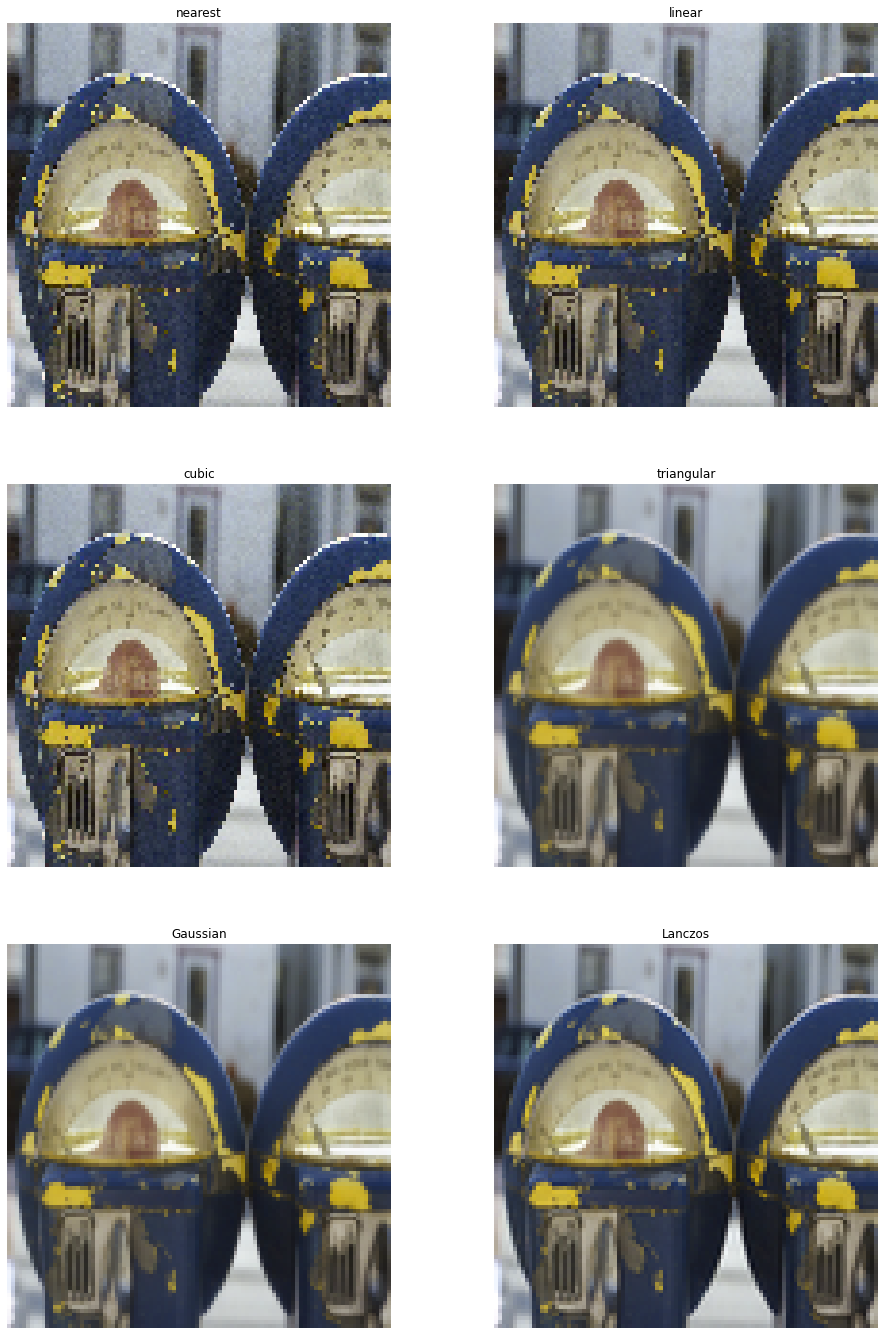

In [5]:
show(pipe_out[1:], 5)

As we can clearly see, nearest, linear and cubic interpolation do not offer any anti-aliasing capability, so they are not suitable for aggressive downscaling.

## Upscaling
Now, let's compare how the interpolation methods fare at upscaling. For good visualization, we'll take a small crop of the input.

In [6]:
batch_size = 32

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(path = db_folder, random_shuffle = True, seed = 1234)
    images = dali.fn.decoders.image(files, device = "mixed")
    
    width = 400
    height = 400
    
    cropped = dali.fn.crop(images, crop=(150,150))

    nearest, linear, cubic, triangular, gaussian, lanczos =  (
        dali.fn.resize(cropped, resize_x=width, resize_y=height, interp_type=interp)
        for interp in [
            dali.types.INTERP_NN,
            dali.types.INTERP_LINEAR,
            dali.types.INTERP_CUBIC,
            dali.types.INTERP_TRIANGULAR,
            dali.types.INTERP_GAUSSIAN,
            dali.types.INTERP_LANCZOS3
        ]
    )
  
    pipe.set_outputs(cropped, nearest, linear, cubic, triangular, gaussian, lanczos)
  
pipe.build()
pipe_out = pipe.run()

Original image


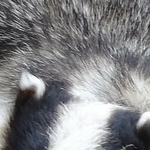

In [7]:
print("Original image")
PIL.Image.fromarray(pipe_out[0].as_cpu().at(1))

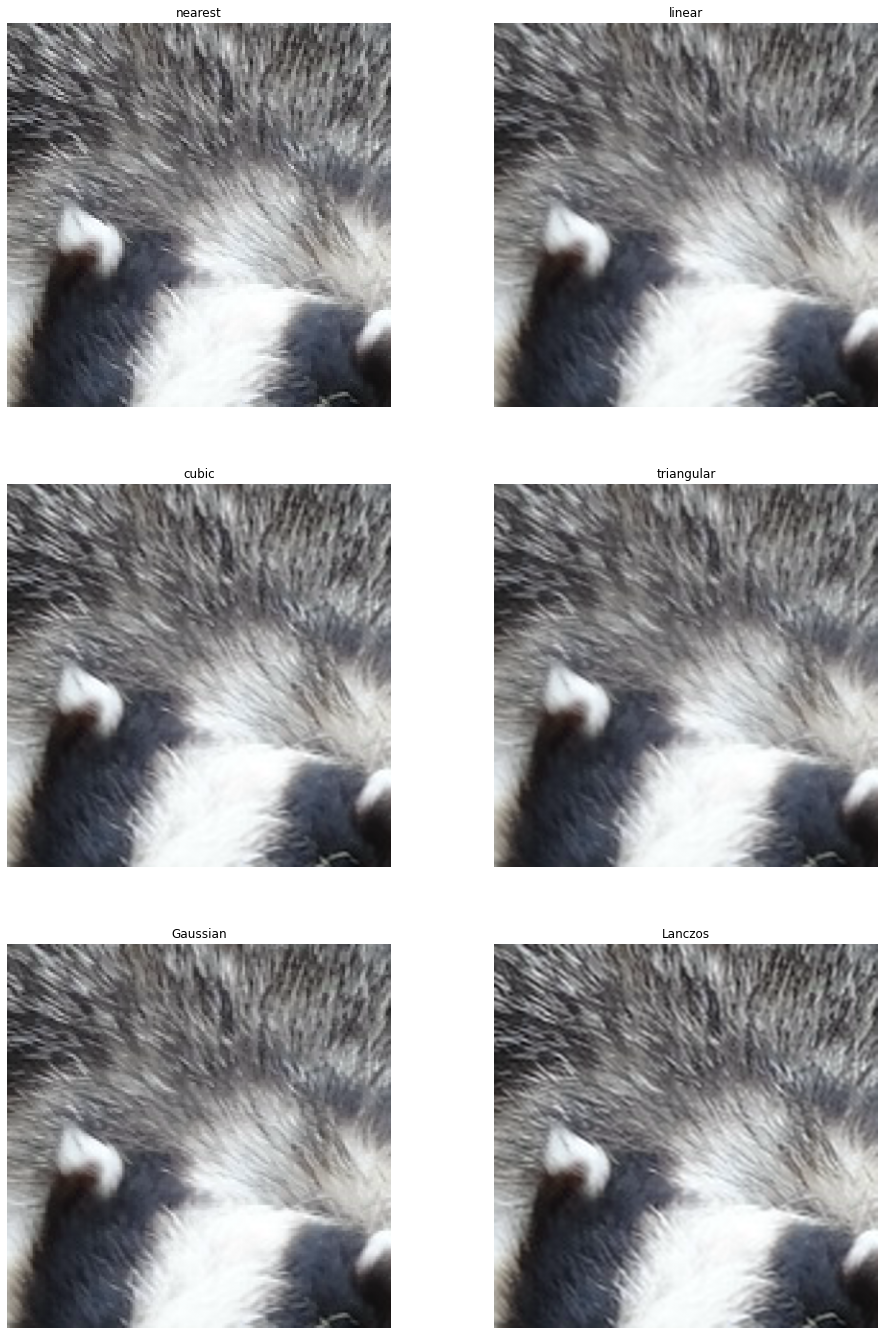

In [8]:
show(pipe_out[1:], 1)

As expected, nearest neighbor interpolation produces severe block artifacs. Linear and triangular interpolation produce exactly the same result for upscaling, while more sophisticated filters produce far better result, but require more computational power.